In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [54]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import re,string,unicodedata
from keras.preprocessing import text, sequence
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from string import punctuation
from nltk import pos_tag
from nltk.corpus import wordnet
import keras
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout
from keras.callbacks import ReduceLROnPlateau
import tensorflow as tf
from keras.utils import pad_sequences

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [2]:
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/wordnet/noun.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/verb.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/README  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.sense  
  inflating: /usr/share/nltk_data

In [6]:
#Import Data
df = pd.read_csv("/kaggle/input/human-stress-prediction/Stress.csv")

In [7]:
df.head()

,subreddit,post_id,sentence_range,text,label,confidence,social_timestamp
0,ptsd,8601tu,"(15, 20)","He said he had not felt that way before, sugge...",1,0.8,1521614353
1,assistance,8lbrx9,"(0, 5)","Hey there r/assistance, Not sure if this is th...",0,1.0,1527009817
2,ptsd,9ch1zh,"(15, 20)",My mom then hit me with the newspaper and it s...,1,0.8,1535935605
3,relationships,7rorpp,"[5, 10]","until i met my new boyfriend, he is amazing, h...",1,0.6,1516429555
4,survivorsofabuse,9p2gbc,"[0, 5]",October is Domestic Violence Awareness Month a...,1,0.8,1539809005


Text(0.5, 0, 'Stres Dagılımı')

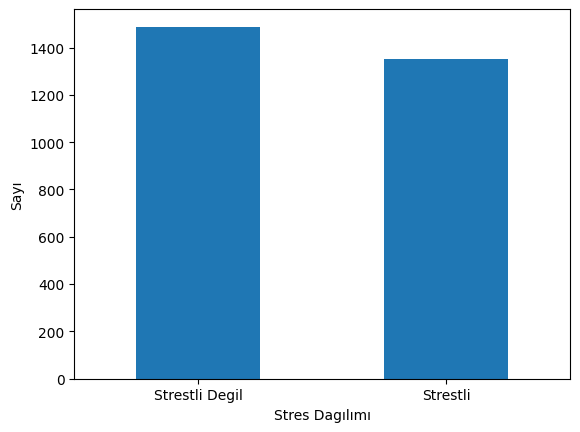

In [9]:
ax = df.label.value_counts().plot(kind='bar')
ax.set_xticks(ticks=[1,0],labels=['Strestli','Strestli Degil'],rotation=0)
plt.ylabel('Sayı')
plt.xlabel('Stres Dagılımı')
 

In [10]:
df.isna().sum()

subreddit           0
post_id             0
sentence_range      0
text                0
label               0
confidence          0
social_timestamp    0
dtype: int64

[Text(0, 0, 'Strestli'), Text(1, 0, 'Strestli Degil')]

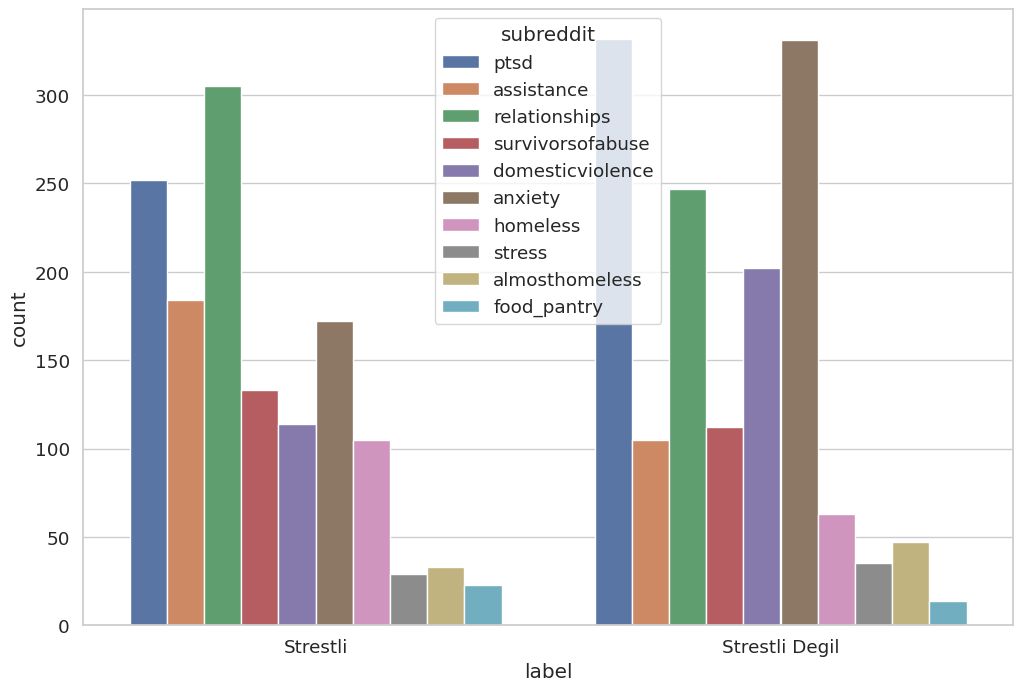

In [12]:
plt.figure(figsize = (12,8))
sns.set(style = "whitegrid",font_scale = 1.2)
chart = sns.countplot(x = "label", hue = "subreddit" , data = data)
#chart.set_xticklabels(chart.get_xticklabels(),rotation=0)
chart.set_xticklabels(labels=['Strestli','Strestli Degil'],rotation=0)

In [13]:
df['text'] =df['subreddit'] + ' '+ df['text']

In [14]:
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

In [15]:
#Stopword Temizleme
wnl = WordNetLemmatizer()
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            final_text.append(i.strip())
    return " ".join(final_text)
df["text"] = df["text"].apply(remove_stopwords)

df["text"] = df["text"].apply(lambda x: " ".join([wnl.lemmatize(word) for word in x.split()]))

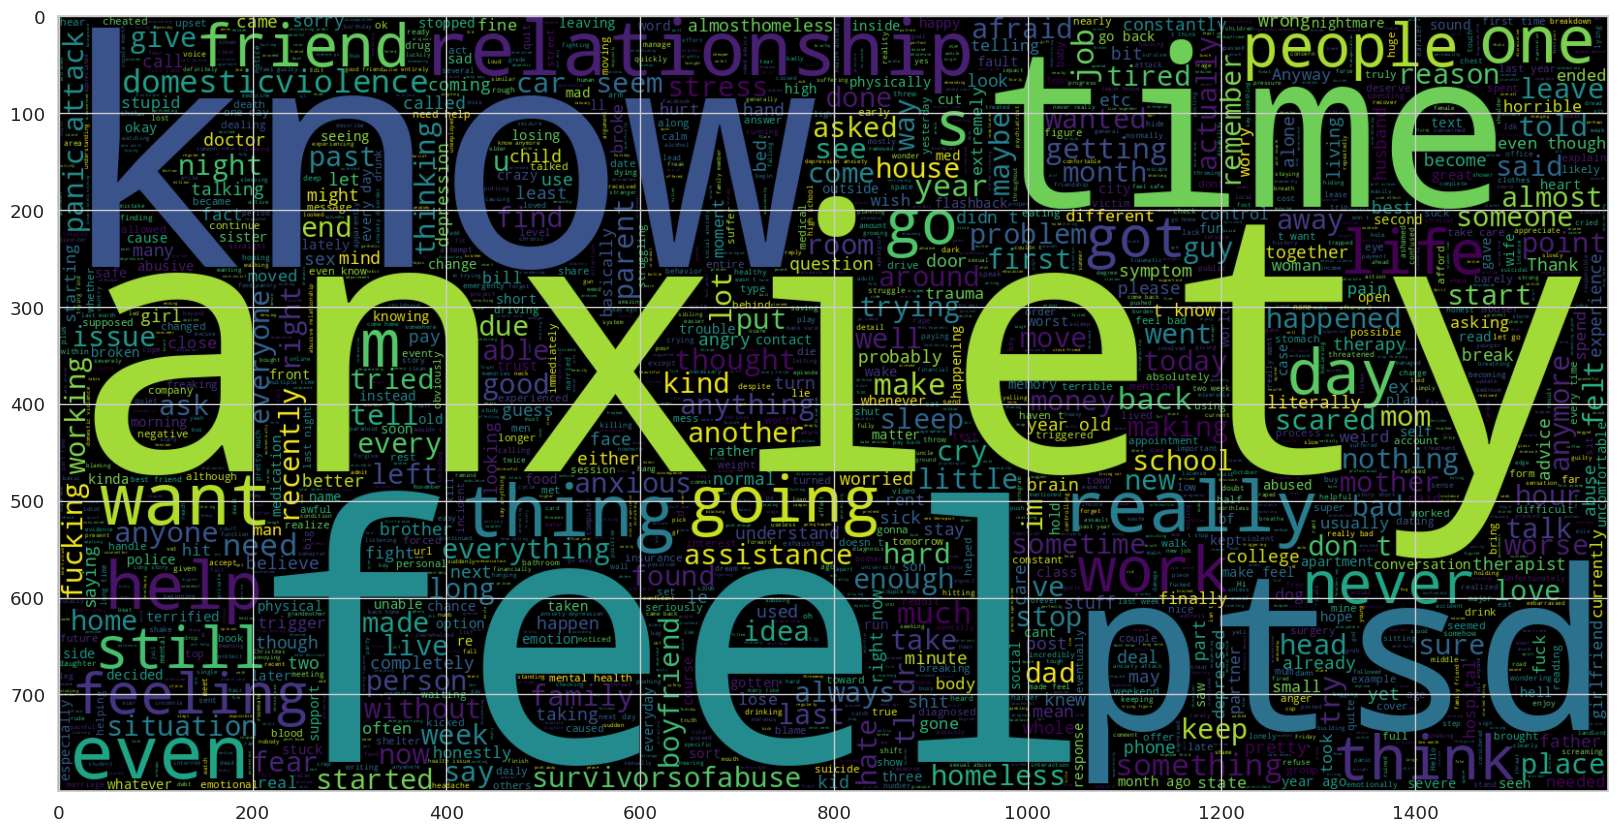

In [18]:
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(" ".join(df[df.label == 1].text))
plt.imshow(wc , interpolation = 'bilinear')

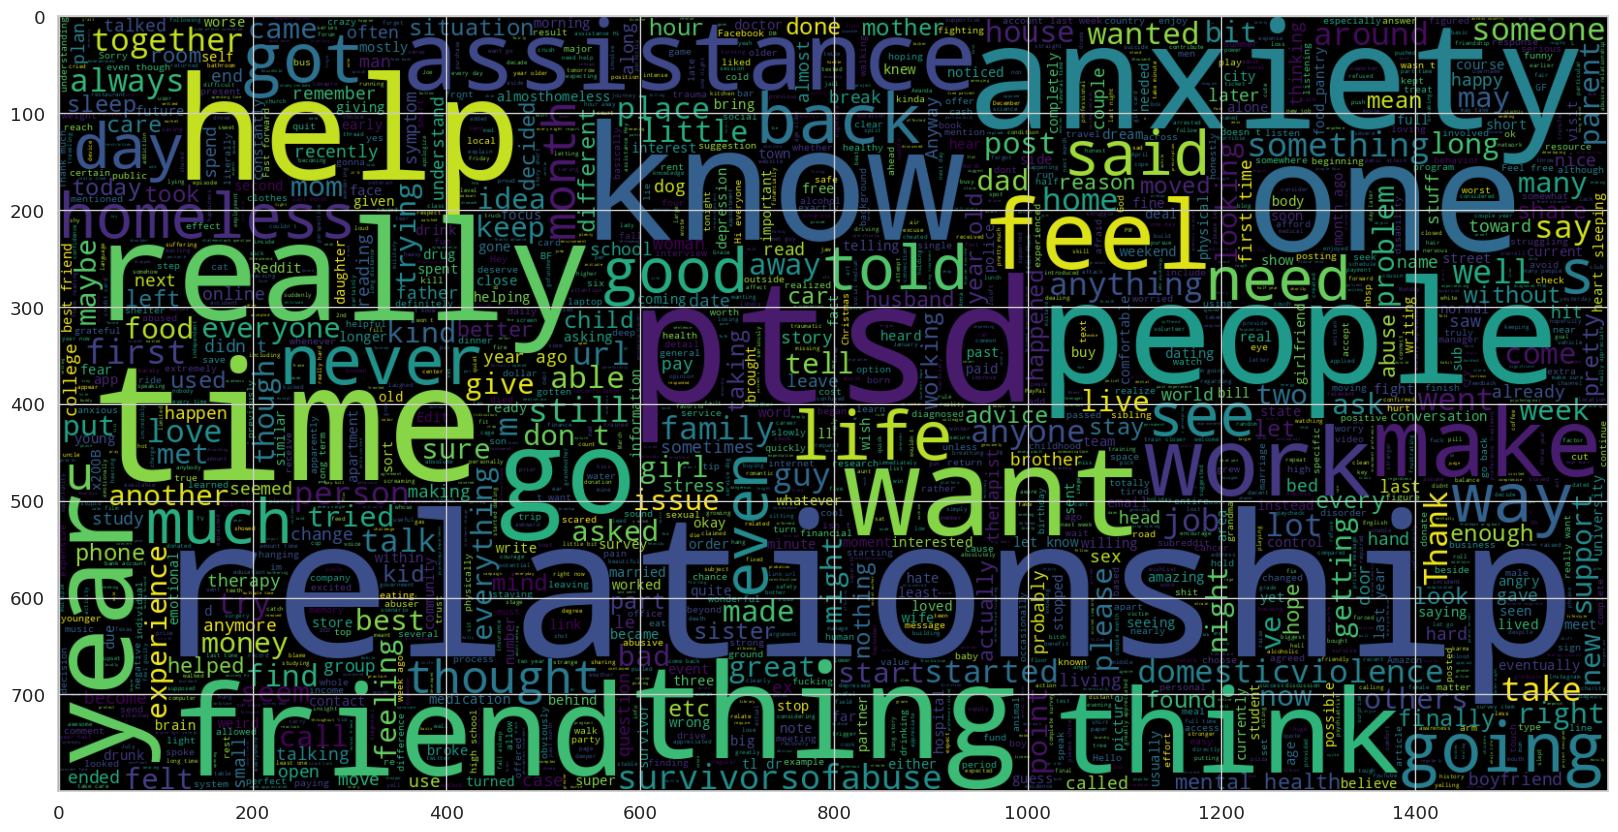

In [19]:
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(" ".join(df[df.label == 0].text))
plt.imshow(wc , interpolation = 'bilinear')

In [37]:
df['text']=df['text'].str.lower()
df['text']=df['text'].str.replace('[^\w\s]','') # noktalama isaretlerini kaldir
df['text']=df['text'].str.replace('\d+','') #rakamlari kaldir
df['text']=df['text'].str.replace('\r','').replace('\n','')

In [38]:
x=df['text']
y=df['label']

In [45]:
df

,subreddit,post_id,sentence_range,text,label,confidence,social_timestamp
0,ptsd,8601tu,"(15, 20)","ptsd said felt way before, suggeted go rest .....",1,0.800000,1521614353
1,assistance,8lbrx9,"(0, 5)","assistance hey r/assistance, sure right place ...",0,1.000000,1527009817
2,ptsd,9ch1zh,"(15, 20)","ptsd mom hit newspaper shocked would this, kno...",1,0.800000,1535935605
3,relationships,7rorpp,"[5, 10]","relationship met new boyfriend, amazing, kind,...",1,0.600000,1516429555
4,survivorsofabuse,9p2gbc,"[0, 5]",survivorsofabuse october domestic violence awa...,1,0.800000,1539809005
...,...,...,...,...,...,...,...
2833,relationships,7oee1t,"[35, 40]","relationship her, week ago: precious, you? (i ...",0,1.000000,1515187044
2834,ptsd,9p4ung,"[20, 25]","ptsd ability cope anymore. i'm trying, lot thi...",1,1.000000,1539827412
2835,anxiety,9nam6l,"(5, 10)",anxiety case first time reading post... lookin...,0,1.000000,1539269312
2836,almosthomeless,5y53ya,"[5, 10]",almosthomeless find normal? good relationship....,0,0.571429,1488938143


In [40]:
from sklearn.feature_extraction.text import CountVectorizer
vect=CountVectorizer(stop_words='english',lowercase=True)
x=vect.fit_transform(x)

In [41]:
x_train,x_test , y_train,y_test = train_test_split(x,y,test_size=0.20,random_state=42)

In [46]:
from sklearn.svm import SVC
s=SVC()
model=s.fit(x_train,y_train)

In [47]:
predict = model.predict(x_test)

In [48]:
accuracy_score(predict,y_test)

0.6936619718309859

<Axes: >

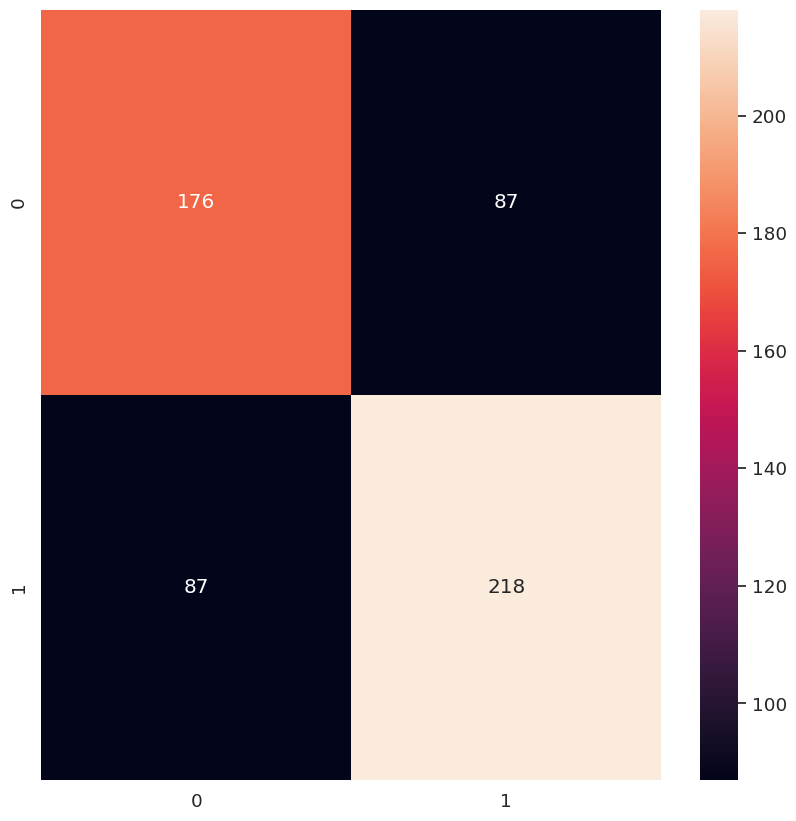

In [49]:
cm = confusion_matrix(list(y_test), predict)
plt.figure(figsize = (10, 10))
sns.heatmap(cm, annot = True,fmt='g')

In [56]:

tree=DecisionTreeClassifier()
tree.fit(x_train,y_train)
print('Dtree ',tree.score(x_test,y_test))

rforest=RandomForestClassifier()
rforest.fit(x_train,y_train)
print('The random forest: ',rforest.score(x_test,y_test))

adb=AdaBoostClassifier()
adb.fit(x_train,y_train)
print('the adb ',adb.score(x_test,y_test))

grb=GradientBoostingClassifier()
grb.fit(x_train,y_train)
print(grb.score(x_test,y_test))

bag=BaggingClassifier()
bag.fit(x_train,y_train)
print(bag.score(x_test,y_test))

knn=KNeighborsClassifier()
knn.fit(x_train,y_train)
print('KNN ',knn.score(x_test,y_test))

Dtree  0.5809859154929577
The random forest:  0.6971830985915493
the adb  0.6566901408450704
0.670774647887324
0.6267605633802817
KNN  0.5686619718309859
